In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd

2024-05-28 05:16:18.062031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 05:16:18.062157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 05:16:18.245238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_images_from_folder1(folder_path):
    images = []
    labels = []

    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" or folder_name == "glucoma" or folder_name=="Glaucoma_Positive" else 0

        for filename in tqdm(os.listdir(folder), desc=f"Loading images", total=total_files):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            if img is not None:
                images.append(img)
                labels.append(label)

    return images, labels

def print_image_characteristics(images, labels):
    print("Number of images:", len(images))
    if len(images) > 0:
      print("Number of Healthy images:", np.count_nonzero(np.array(labels) == 0))
      print("Number of Glaucomatous images:", np.count_nonzero(np.array(labels) == 1))
      print("Image dimensions:", images[0].shape)
      print("Data type:", images[0].dtype)
      print("Range of pixel values:", np.min(images), "-", np.max(images))

# Load images from folder
images_folder_path = '/kaggle/input/g1020-final/G1020'
images, labels = load_images_from_folder1(images_folder_path)

print_image_characteristics(images, labels)

Loading images:  27%|██▋       | 284/1041 [00:02<00:07, 99.31it/s] 


Number of images: 1041
Number of Healthy images: 757
Number of Glaucomatous images: 284
Image dimensions: (224, 224, 3)
Data type: uint8
Range of pixel values: 0 - 255


In [3]:
def load_images_from_folder(folder_path):
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" or folder_name == "glucoma" or folder_name=="Glaucoma_Positive" else 0

        for filename in tqdm(os.listdir(folder), desc=f"Loading images", total=total_files):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            if img is not None:
                images.append(img)
                labels.append(label)

    return images, labels

# Load images from the folder
images_folder_path = '/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
images, labels = load_images_from_folder(images_folder_path)

print_image_characteristics(images, labels)

Loading images:  26%|██▌       | 134/520 [00:09<00:26, 14.73it/s]


Number of images: 1561
Number of Healthy images: 1143
Number of Glaucomatous images: 418
Image dimensions: (224, 224, 3)
Data type: uint8
Range of pixel values: 0 - 255


In [4]:
# Load images from the folder
images_folder_path = '/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'
images, labels = load_images_from_folder(images_folder_path)

print_image_characteristics(images, labels)

Loading images:  26%|██▌       | 34/130 [00:02<00:06, 15.65it/s]


Number of images: 1691
Number of Healthy images: 1239
Number of Glaucomatous images: 452
Image dimensions: (224, 224, 3)
Data type: uint8
Range of pixel values: 0 - 255


In [5]:
# Function to load images from a folder and assign all labels as 1
def load_images_from_folder(folder_path):
    # Get total number of files for progress bar
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])

    # Iterate over all files in the folder
    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        # Assign label 1 to all images
        label = 0

        # Load images and resize them
        if folder_name=='image':
            for filename in tqdm(os.listdir(folder), desc=f"Loading images from {folder_name}", total=total_files):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(label)

    return images, labels

# Load images from the specified folder
images_folder_path = '/kaggle/input/lag-dataset/non_glaucoma'
images, labels = load_images_from_folder(images_folder_path)

# Print image characteristics
print_image_characteristics(images, labels)


Loading images from image:  33%|███▎      | 3143/9429 [00:29<00:58, 107.40it/s]


Number of images: 4834
Number of Healthy images: 4382
Number of Glaucomatous images: 452
Image dimensions: (224, 224, 3)
Data type: uint8
Range of pixel values: 0 - 255


In [6]:
# Function to load images from a folder and assign all labels as 1
def load_images_from_folder(folder_path):
    # Get total number of files for progress bar
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])

    # Iterate over all files in the folder
    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        # Assign label 1 to all images
        label = 1

        # Load images and resize them
        if folder_name=='image':
            for filename in tqdm(os.listdir(folder), desc=f"Loading images from {folder_name}", total=total_files):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(label)

    return images, labels

# Load images from the specified folder
images_folder_path = '/kaggle/input/lag-dataset/suspicious_glaucoma'
images, labels = load_images_from_folder(images_folder_path)

# Print image characteristics
print_image_characteristics(images, labels)

Loading images from image:  33%|███▎      | 1711/5133 [00:14<00:29, 116.56it/s]


Number of images: 6545
Number of Healthy images: 4382
Number of Glaucomatous images: 2163
Image dimensions: (224, 224, 3)
Data type: uint8
Range of pixel values: 0 - 255


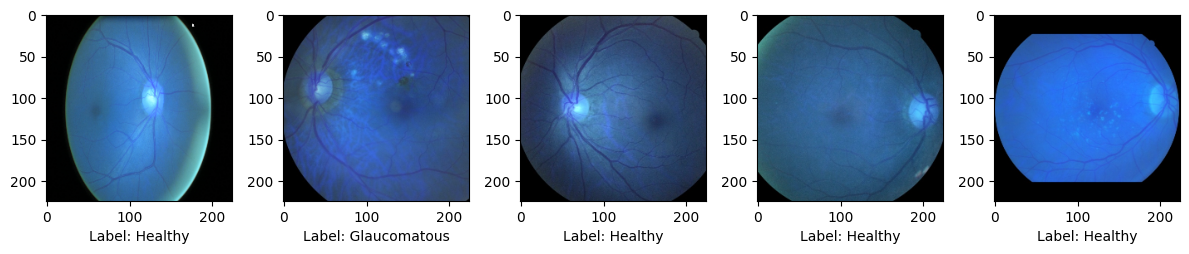

In [7]:
def plot_images(images, labels):
  plt.figure(figsize=(12,7))
  for i in range(5):
      sample = random.choice(range(len(images)))
      image = images[sample]
      categ = labels[sample]

      label = "Glaucomatous" if categ==1 else "Healthy"

      plt.subplot(2, 5, i + 1)
      plt.imshow(image)
      plt.xlabel(f"Label: {label}")

  plt.tight_layout()
  plt.show()

plot_images(images, labels)

Applying blur threshold: 100%|██████████| 6545/6545 [00:00<00:00, 17751.78it/s]


Number of images: 6545
Number of Healthy images: 4382
Number of Glaucomatous images: 2163
Image dimensions: (224, 224, 3)
Data type: uint8
Range of pixel values: 0 - 255


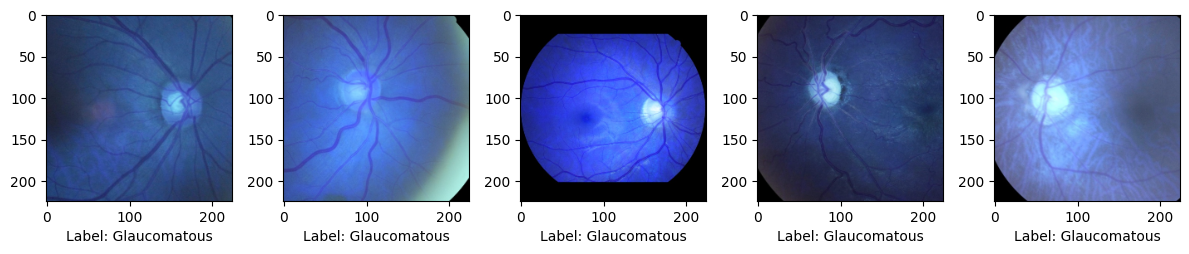

In [8]:
def apply_laplacian_method(image):
    img = cv2.resize(image, (14, 14))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.Laplacian(gray, cv2.CV_64F).var()
    return blur

def apply_laplacian_threshold(images, labels, threshold):
    filtered_images = []
    filtered_labels = []

    for i in tqdm(range(len(images)), desc="Applying blur threshold"):
        blur = apply_laplacian_method(images[i])
        if blur > threshold:
            filtered_images.append(images[i])
            filtered_labels.append(labels[i])

    return np.array(filtered_images), np.array(filtered_labels)

threshold=50
filtered_images, filtered_labels = apply_laplacian_threshold(images, labels, threshold)
print_image_characteristics(filtered_images, filtered_labels)
plot_images(filtered_images, filtered_labels,)

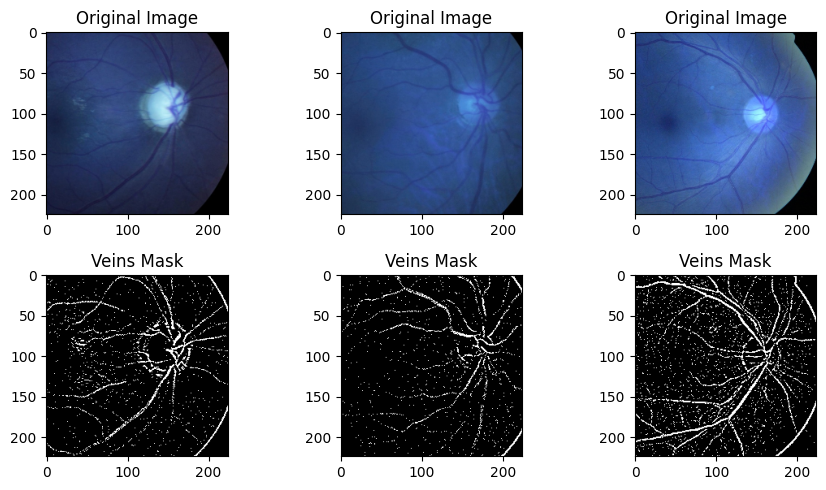

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, binary_erosion, binary_dilation

def preprocess_image(image_path):
  masks=[]
  preprocessed_images=[]

  for img in image_path:
    # Read the image
    img_color = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    img_blur = cv2.GaussianBlur(img, (3, 3), 0)

    # Enhance veins using a high-pass filter (Laplacian)
    laplacian = cv2.Laplacian(img_blur, cv2.CV_64F)

    # Threshold the image to capture veins
    _, veins_mask = cv2.threshold(laplacian, 3, 255, cv2.THRESH_BINARY)

     # Convert veins mask to binary (0 and 1)
    binary_veins_mask = (veins_mask / 255).astype(np.uint8)

    # Apply morphological operations to remove single dots
    kernel = np.ones((1, 1), np.uint8)
    binary_veins_mask = cv2.morphologyEx(binary_veins_mask, cv2.MORPH_CLOSE, kernel)
    masks.append(binary_veins_mask)

    veins_mask_rgb = np.stack([binary_veins_mask] * 3, axis=-1)

    # Overlay veins mask on the original image
    preprocessed_image = img_color.copy()
    preprocessed_image[veins_mask_rgb == 1] = 255

    preprocessed_images.append(preprocessed_image)

  return np.array(masks), np.array(preprocessed_images)


def plot_images_masks(images, veins_mask, preprocessed_images, labels):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        sample = random.choice(range(len(images)))
        image = images[sample]
        mask = veins_mask[sample]
        pre_image = preprocessed_images[sample]
        category = labels[sample]

        label = 'Glaucomatous' if category == 1 else 'Healthy'

        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')

        plt.subplot(2, 5, i + 6)
        plt.imshow(mask, cmap='gray')
        plt.title('Veins Mask')

    plt.tight_layout()
    plt.show()


image_path = filtered_images
label= filtered_labels

veins_mask, preprocessed_images = preprocess_image(image_path)
plot_images_masks(filtered_images, veins_mask, preprocessed_images, filtered_labels)

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import cv2
from tqdm import tqdm

# Load VGG19 model pretrained on ImageNet
base_model = VGG19(weights='imagenet', include_top=False)

# Create a new model that outputs the features from an intermediate layer
layer_name = 'block5_conv4'  # You can choose any layer
intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# Function to preprocess and load images
def preprocess_image(img_array, target_size=(224, 224)):
    img = cv2.resize(img_array, target_size)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Function to extract features from a list of image arrays
def extract_features_from_images(image_arrays):
    features = []
    for img_array in tqdm(image_arrays, desc="Extracting features"):
        img_preprocessed = preprocess_image(img_array)
        feature = intermediate_layer_model.predict(img_preprocessed, verbose=0)
        features.append(feature.squeeze())
    return np.array(features)

# Example usage
# Assuming `filtered_images` is a list of image arrays loaded into memory
# filtered_images = [cv2.imread(path) for path in image_paths]

# Extract features from the list of image arrays
features = extract_features_from_images(filtered_images)

# Print the shape of the extracted features
print("Shape of extracted features:", features.shape)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting features:   0%|          | 0/6545 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1716873524.823435      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting features: 100%|██████████| 6545/6545 [08:35<00:00, 12.71it/s]


Shape of extracted features: (6545, 14, 14, 512)


In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, accuracy_score, recall_score


# Assume you have labels corresponding to the images
# labels should be a list or array with 1 for glaucoma and 0 for non-glaucoma
# For example: labels = [1, 0, 1, 0, 0, 1, ...]

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(features, filtered_labels, test_size=0.2, random_state=42)

# Create the binary classification model
model = Sequential([
    Flatten(input_shape=features.shape[1:]),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


checkpoint_path = '/kaggle/working/model.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, callbacks=[model_checkpoint])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print('Validation accuracy:', val_acc)

# Predict the labels for the validation set
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Print accuracy and recall
val_acc = accuracy_score(y_val, y_pred)
val_recall = recall_score(y_val, y_pred)

print(f'Validation Accuracy: {val_acc}')
print(f'Validation Recall: {val_recall}')

# Generate and print classification report
report = classification_report(y_val, y_pred, target_names=['Non-Glaucoma', 'Glaucoma'])
print(report)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
 10/164 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5653 - loss: 25.8888

W0000 00:00:1716874046.657607      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6695 - loss: 20.1888

W0000 00:00:1716874053.038390      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716874054.667181      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.84492, saving model to /kaggle/working/model.keras


W0000 00:00:1716874055.516957      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.6698 - loss: 20.1380 - val_accuracy: 0.8449 - val_loss: 0.8754
Epoch 2/20
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7709 - loss: 1.4461
Epoch 2: val_accuracy did not improve from 0.84492
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7711 - loss: 1.4406 - val_accuracy: 0.8403 - val_loss: 0.3886
Epoch 3/20
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7999 - loss: 0.5973
Epoch 3: val_accuracy improved from 0.84492 to 0.85409, saving model to /kaggle/working/model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7999 - loss: 0.5972 - val_accuracy: 0.8541 - val_loss: 0.4530
Epoch 4/20
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8052 - loss: 0.5146
Epoch 4: val_accuracy improved from 0.85409 to 0.85561, saving model to /kaggle/working/model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8051 - loss: 0.5147 - val_accuracy: 0.8556 - val_loss: 0.3896
Epoch 5/20
163

W0000 00:00:1716874150.324795      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Validation Accuracy: 0.8609625668449198
Validation Recall: 0.6873449131513648
              precision    recall  f1-score   support

Non-Glaucoma       0.87      0.94      0.90       906
    Glaucoma       0.83      0.69      0.75       403

    accuracy                           0.86      1309
   macro avg       0.85      0.81      0.83      1309
weighted avg       0.86      0.86      0.86      1309



W0000 00:00:1716874150.746841      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


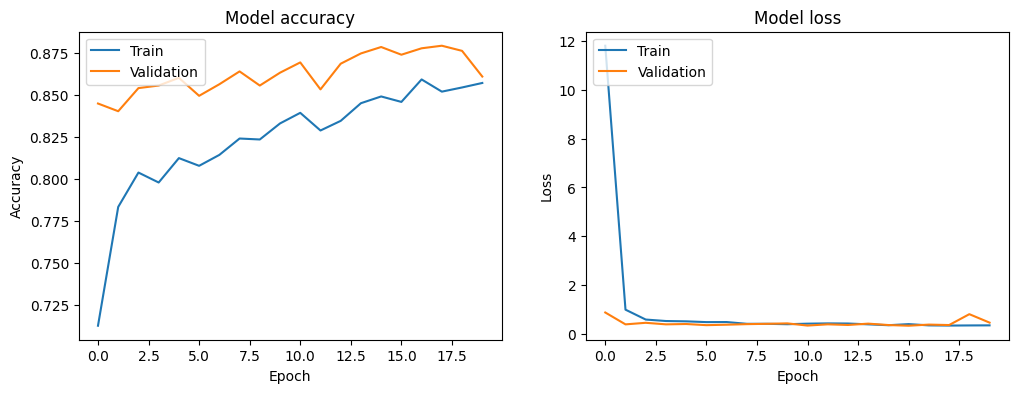

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


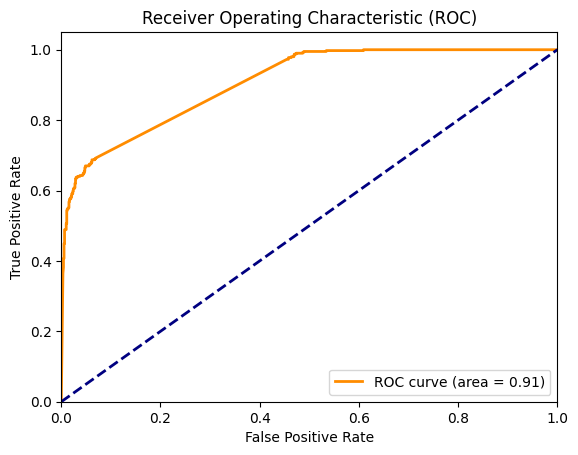

In [13]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Predictions for ROC curve and confusion matrix
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

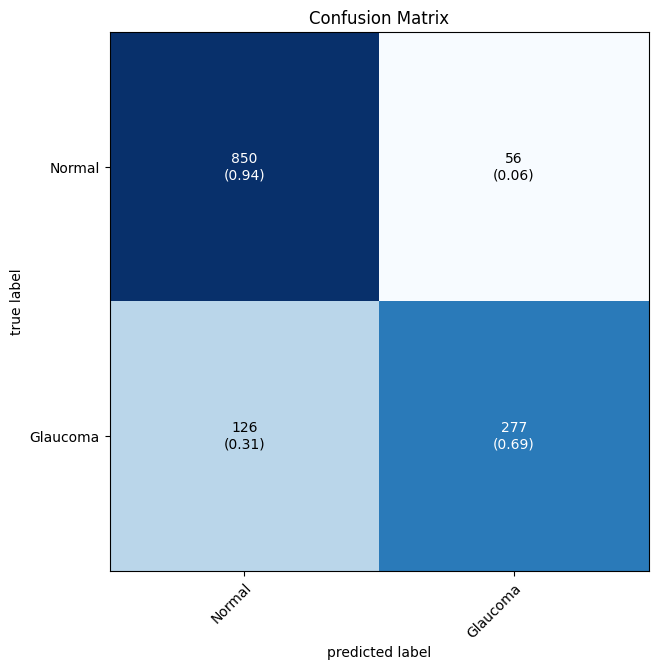

In [14]:
# Confusion Matrix
def plot_conf_matrix(labels, preds):
  cm = confusion_matrix(labels, preds)
  plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Glaucoma"], show_normed=True)
  plt.title("Confusion Matrix")  # Add title here
  plt.show()
plot_conf_matrix(y_val, y_pred)

In [15]:
model.save('/kaggle/working/model.keras')

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import os

# Load the pretrained VGG19 model without the top classification layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the new model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # You can also use Flatten() here
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Load weights if you have trained the model previously

# Function to preprocess an image for prediction
def preprocess_image(image, target_size=(224, 224)):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more image formats if needed
            img_path = os.path.join(folder_path, filename)
            image = load_img(img_path, target_size=(224, 224))
            images.append(image)
            filenames.append(filename)
    return images, filenames

# Function to make predictions on a list of images
def predict_images(images):
    predictions = []
    for image in tqdm(images, desc="Predicting images"):
        img_preprocessed = preprocess_image(image)
        prediction = model.predict(img_preprocessed, verbose=0)
        predictions.append(prediction[0])
    return predictions

# Function to calculate the percentage of each class
def calculate_percentage(predictions, threshold=0.5):
    num_glaucoma = sum(pred > threshold for pred in predictions)
    num_non_glaucoma = len(predictions) - num_glaucoma
    total = len(predictions)
    glaucoma_percentage = (num_glaucoma / total) * 100
    non_glaucoma_percentage = (num_non_glaucoma / total) * 100
    return glaucoma_percentage, non_glaucoma_percentage
# Specify the folder path containing the images
folder_path = '/kaggle/input/g1020-final/G1020/glucoma'

# Load images from the folder
images, filenames = load_images_from_folder(folder_path)

# Make predictions on the loaded images
predictions = predict_images(images)

# Calculate the percentage of each class
glaucoma_percentage, non_glaucoma_percentage = calculate_percentage(predictions)

# Print the results
print(f'Glaucoma Percentage: {glaucoma_percentage}%')
print(f'Non-Glaucoma Percentage: {non_glaucoma_percentage}%')

Predicting images: 100%|██████████| 284/284 [00:23<00:00, 12.01it/s]

Glaucoma Percentage: [10.91549296]%
Non-Glaucoma Percentage: [89.08450704]%
